In [33]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 6)

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

<h3>1. Считываем данные по индексу RTSI, Brent, Usd/Rub, S&P 500 за годы 2010-2016</h3>

In [34]:
rtsi_df = pd.read_csv('data/RTSI_2010-2016.csv')
brent_df = pd.read_csv('data/Brent_2010-2016.csv')
usdrub_df = pd.read_csv('data/USD_RUB_2010-2016.csv')
sandp_df = pd.read_csv('data/SANDP-500_2010-2016.csv')

<h3>2. Избавляемся от ненужных фич, добавляем пропущенные выходные дни и новые фичи</h3>
<h4>Новые фичи:</h4>
<p>Берем биржевые данные по Brent, Usd/Rub и S&P 500. Находим, что произошло с этими инструментами за день до интересующего нас дня. 0 - если цена инструмента за день не изменилась, 1 - если выросла, 2 - если упала. Используем эти данные для предсказания поведения индекса RTSI на следующий день.</p>

In [35]:
def process(df, date_low, date_up):
    df.drop(['<TIME>', '<HIGH>', '<LOW>', '<VOL>'], axis=1, inplace=True)
    
    # 0 - цена не изменилась
    # 1 - цена выросла
    # 2 - цена упала
    df['diff'] = (df['<CLOSE>'] - df['<OPEN>']).astype(float)
    df['result'] = df['diff'].apply(lambda d: 1 if d > 0 else 2 if d < 0 else 0)
    df.drop(['<OPEN>', '<CLOSE>', 'diff'], axis=1, inplace=True)
    
    df.set_index('<DATE>', inplace=True)
    
    idx = pd.date_range(date_low, date_up)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    
    df = df.reset_index()
    df = df.rename(columns = {'index': '<DATE>'})
    
    return df

In [36]:
rtsi_df = process(rtsi_df, '01/01/10', '12/31/2016')

brent_df = process(brent_df, '12/31/09', '12/30/2016')
usdrub_df = process(usdrub_df, '12/31/09', '12/30/2016')
sandp_df = process(sandp_df, '12/31/09', '12/30/2016')

In [37]:
df = rtsi_df
df['brent'] = brent_df['result']
df['usd_rub'] = usdrub_df['result']
df['sandp'] = sandp_df['result']

In [38]:
df.head()

,<DATE>,result,brent,usd_rub,sandp
0,2010-01-01,0,2,2,2
1,2010-01-02,0,0,1,1
2,2010-01-03,0,0,0,0
3,2010-01-04,0,0,0,0
4,2010-01-05,0,1,2,1


<h3>3. Форматируем данные</h3>

In [39]:
df['weekday'] = df['<DATE>'].apply(lambda d: d.weekday())
df['month'] = df['<DATE>'].apply(lambda d: d.month)
df.drop('<DATE>', axis=1, inplace=True)

In [40]:
df.head()

,result,brent,usd_rub,sandp,weekday,month
0,0,2,2,2,4,1
1,0,0,1,1,5,1
2,0,0,0,0,6,1
3,0,0,0,0,0,1
4,0,1,2,1,1,1


<h3>4. Смотрим на пару табличек и графиков, построенных по нашим данным</h3>

In [41]:
df['result'].value_counts()

1    886
2    866
0    805
Name: result, dtype: int64

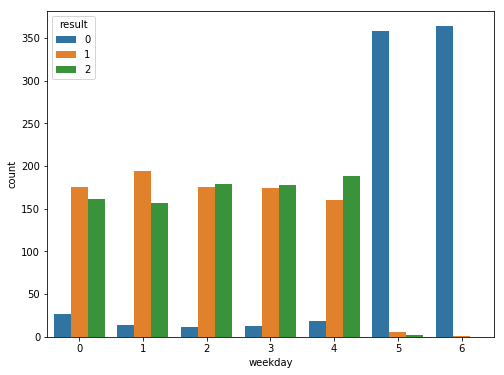

In [42]:
sns.countplot(x='weekday', hue='result', data=df);

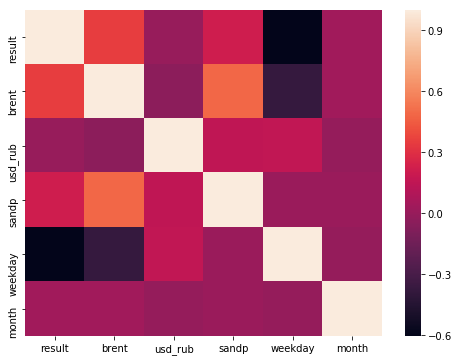

In [43]:
sns.heatmap(df.corr());

<h3>5. Обучаем несколько моделей (kNN, дерево решений, логистическая регрессия, нейронная сеть, SVM)</h3>
<h4>Как работает дерево решений?</h4>
<p>Классическое дерево решений как алгоритм машинного обучения объединяет логические правила вида "Значение признака  $a$  меньше  $x$ => одно из искомых значений (0,1,2)". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по визуализации нашего дерева видно, что в корне дерева проверяется день недели: если это суббота или воскресенье, то практически наверняка цена не изменится и модель прескажет 0</p>
<h4>Как работает kNN?</h4>
<p>Метод ближайших соседей (k Nearest Neighbors, или kNN) - тоже очень популярный метод классификации. Например, если ты хочешь предсказать результат торгов в субботу, посмотри на другие похожие дни (то есть выходные) и выбери преобладающее среди них значение результата торгов - скорее всего, получишь 0</p>

In [44]:
y = df['result'].values
df.drop('result', axis=1, inplace=True)

In [45]:
X_train, X_cv, y_train, y_cv = train_test_split(df.values, y, test_size=0.3, random_state=17)

In [46]:
tree_params = {'max_depth': range(1,30), 'min_samples_leaf': range(1,30)}

model = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_cv)

print("tree(train) accuracy =", accuracy_score(y_train, trainPredict))
print("tree(test) accuracy =", accuracy_score(y_cv, testPredict))
print(model.best_params_)

tree(train) accuracy = 0.672442705422
tree(test) accuracy = 0.630208333333
{'min_samples_leaf': 9, 'max_depth': 6}


In [47]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 20)}

model = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_cv)

print("kNN(train) accuracy =", accuracy_score(y_train, trainPredict))
print("kNN(test) accuracy =", accuracy_score(y_cv, testPredict))
print(model.best_params_)

kNN(train) accuracy = 0.677473448854
kNN(test) accuracy = 0.6171875
{'knn__n_neighbors': 18}


In [48]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_cv_poly = poly.fit_transform(X_cv)

model = LogisticRegression()
model.fit(X_train_poly, y_train)
trainPredict = model.predict(X_train_poly)
testPredict = model.predict(X_cv_poly)

print("LogisticRegression(train) accuracy =", accuracy_score(y_train, trainPredict))
print("LogisticRegression(test) accuracy =", accuracy_score(y_cv, testPredict))

LogisticRegression(train) accuracy = 0.646730016769
LogisticRegression(test) accuracy = 0.66015625


In [49]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_cv_norm = scaler.transform(X_cv)

model = MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000))
# nn = GridSearchCV(MLPRegressor(), param_grid={
#     'alpha': 10.0 ** -np.arange(1, 7),
#     'hidden_layer_sizes': [(100), (100, 100), (200, 200)]},
#     cv=5, n_jobs=4, verbose=True
# )
model.fit(X_train_norm, y_train)
trainPredict = model.predict(X_train_norm)
testPredict = model.predict(X_cv_norm)

print("MLPClassifier(train) accuracy =", accuracy_score(y_train, trainPredict))
print("MLPClassifier(test) accuracy =", accuracy_score(y_cv, testPredict))
# print(model.best_params_)

MLPClassifier(train) accuracy = 0.686975964226
MLPClassifier(test) accuracy = 0.6484375


In [50]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_cv_norm = scaler.transform(X_cv)

model = SVC()
model.fit(X_train_norm, y_train)
trainPredict = model.predict(X_train_norm)
testPredict = model.predict(X_cv_norm)

print("SVM(train) accuracy =", accuracy_score(y_train, trainPredict))
print("SVM(test) accuracy =", accuracy_score(y_cv, testPredict))

SVM(train) accuracy = 0.683622135271
SVM(test) accuracy = 0.6484375


<h4> Средняя доля правильных ответов на тестовой выборке составляет примерно 66%</h4>